# Model and Training

## Load the model

In [1]:
import os
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import transforms, datasets
from diffusers import UNet2DModel, DDPMScheduler, DDIMScheduler
ON_COLAB = False  # Set to True if running on Google Colab
if ON_COLAB:
    !pip install dotenv
    
from dotenv import load_dotenv

# Load environment variables from .env file
load_dotenv()


# Configuration
target_size_for_training = (128, 128)
data_root = f"./raw_data"  # root directory containing 'train' and 'test' subfolders
if ON_COLAB:
    from google.colab import drive

    drive.mount(os.getenv("GOOGLE_DRIVE_CONTENT_PATH", "/content/drive"))
    data_root = os.getenv("GOOGLE_DRIVE_PATH_RESIZED", data_root)

train_dir = os.path.join(data_root, "train")
test_dir = os.path.join(data_root, "test")
model_save_dir = os.getenv("MODEL_SAVE_DIR", "./checkpoints")
os.makedirs(model_save_dir, exist_ok=True)
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
LEARNING_RATE = 1e-4
IMAGE_SIZE = target_size_for_training[0]

# 2. Define the UNet diffusion model
from model_enrico import get_unet_model

model = get_unet_model(
    sample_size=IMAGE_SIZE,
    in_channels=1,
    out_channels=1,
    layers_per_block=2,
    block_out_channels=(64, 128, 256),
    down_block_types=("DownBlock2D", "DownBlock2D", "AttnDownBlock2D"),
    up_block_types=("AttnUpBlock2D", "UpBlock2D", "UpBlock2D"),
    dropout=0.1,
).to(DEVICE)

# Print model summary
def print_model_summary(model):
    print("Model Summary:")
    print(f"Model Type: {type(model).__name__}")
    print(f"Number of Parameters: {sum(p.numel() for p in model.parameters())}")
    print(f"Device: {next(model.parameters()).device}")

print_model_summary(model)


# 5. Load the model checkpoint if available
def load_checkpoint(ckpt_path, model, optimizer=None, device=torch.device("cpu")):
    loaded = False
    if not os.path.exists(ckpt_path):
        print(f"No checkpoint found at {ckpt_path}, starting fresh.")
        return loaded, model, optimizer, 0

    checkpoint = torch.load(ckpt_path, map_location=device)
    model.load_state_dict(checkpoint["model"])
    model.to(device)
    loaded = True
    start_epoch = checkpoint.get("epoch", 0)
    if optimizer is not None and "optimizer" in checkpoint:
        optimizer.load_state_dict(checkpoint["optimizer"])
        print(f"Loaded optimizer state from checkpoint '{ckpt_path}'")
    else:
        print("Optimizer state not found in checkpoint, starting with a new optimizer.")
    print(f"Loaded checkpoint '{ckpt_path}' (epoch {start_epoch})")
    return loaded, model, optimizer, start_epoch

WEIGHT_DECAY = 1e-5  # weight decay for regularization
optimizer = torch.optim.Adam(
    model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY
)

# Load the model checkpoint
ckpt = "checkpoints/ddim_unet_epoch25.pth"
isModelLoadedFromCheckpoint, model, optimizer, start_epoch = load_checkpoint(
    ckpt, model, optimizer, device=DEVICE
)
model.eval()
if isModelLoadedFromCheckpoint:
    print(f"Model {ckpt.split('/')[-1]} loaded and moved to {DEVICE}, starting from epoch {start_epoch}.")
else:
    print(f"Model {ckpt.split('/')[-1]} not found. Starting from scratch, loaded on {DEVICE}, starting from epoch {start_epoch}.")

/home/enrico/Desktop/Project-Correction/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Model Summary:
Model Type: UNet2DModel
Number of Parameters: 15722625
Device: cuda:0
No checkpoint found at checkpoints/ddim_unet_epoch25.pth, starting fresh.
Model ddim_unet_epoch25.pth not found. Starting from scratch, loaded on cuda, starting from epoch 0.


## Training and validation

Training images before augmentation: 3306
Validation images before augmentation: 327
Training samples: 13224
Validation samples: 1308
Training on cuda | Batch Size: 16 | Epochs: 15 | Starting at epoch 0
[Epoch 1/15 | Step 50/827] Train Loss: 0.054032
[Epoch 1/15 | Step 100/827] Train Loss: 0.065097
[Epoch 1/15 | Step 150/827] Train Loss: 0.029885
[Epoch 1/15 | Step 200/827] Train Loss: 0.023501
[Epoch 1/15 | Step 250/827] Train Loss: 0.038272
[Epoch 1/15 | Step 300/827] Train Loss: 0.022445
[Epoch 1/15 | Step 350/827] Train Loss: 0.015688
[Epoch 1/15 | Step 400/827] Train Loss: 0.015691
[Epoch 1/15 | Step 450/827] Train Loss: 0.018529
[Epoch 1/15 | Step 500/827] Train Loss: 0.023079
[Epoch 1/15 | Step 550/827] Train Loss: 0.031810
[Epoch 1/15 | Step 600/827] Train Loss: 0.008452
[Epoch 1/15 | Step 650/827] Train Loss: 0.012981
[Epoch 1/15 | Step 700/827] Train Loss: 0.037972
[Epoch 1/15 | Step 750/827] Train Loss: 0.021870
[Epoch 1/15 | Step 800/827] Train Loss: 0.011344


W0514 12:30:00.521000 19815 torch/_inductor/utils.py:1250] [0/1] Not enough SMs to use max_autotune_gemm mode


[Epoch 1/15 | Step 827/827] Train Loss: 0.009999


Sampling DDIM: 100%|██████████| 1000/1000 [00:25<00:00, 39.56it/s]


Sample saved to ./checkpoints/epoch_1.png
Epoch 1 complete. Avg Train Loss: 0.039931
Epoch 1 complete. Avg Validation Loss: 0.016541
Checkpoint salvato in: ./checkpoints/ddim_unet_epoch1.pth
[Epoch 2/15 | Step 50/827] Train Loss: 0.006287
[Epoch 2/15 | Step 100/827] Train Loss: 0.030320
[Epoch 2/15 | Step 150/827] Train Loss: 0.012031
[Epoch 2/15 | Step 200/827] Train Loss: 0.008084
[Epoch 2/15 | Step 250/827] Train Loss: 0.012162
[Epoch 2/15 | Step 300/827] Train Loss: 0.034821
[Epoch 2/15 | Step 350/827] Train Loss: 0.006094
[Epoch 2/15 | Step 400/827] Train Loss: 0.008369
[Epoch 2/15 | Step 450/827] Train Loss: 0.041663
[Epoch 2/15 | Step 500/827] Train Loss: 0.033581
[Epoch 2/15 | Step 550/827] Train Loss: 0.015212
[Epoch 2/15 | Step 600/827] Train Loss: 0.016571
[Epoch 2/15 | Step 650/827] Train Loss: 0.008693
[Epoch 2/15 | Step 700/827] Train Loss: 0.022322
[Epoch 2/15 | Step 750/827] Train Loss: 0.006750
[Epoch 2/15 | Step 800/827] Train Loss: 0.008858
[Epoch 2/15 | Step 827/827

Sampling DDIM: 100%|██████████| 1000/1000 [00:22<00:00, 44.97it/s]

Sample saved to ./checkpoints/epoch_2.png
Epoch 2 complete. Avg Train Loss: 0.017938


Epoch 2 complete. Avg Validation Loss: 0.012840
Checkpoint salvato in: ./checkpoints/ddim_unet_epoch2.pth
[Epoch 3/15 | Step 50/827] Train Loss: 0.014477
[Epoch 3/15 | Step 100/827] Train Loss: 0.012741
[Epoch 3/15 | Step 150/827] Train Loss: 0.011284
[Epoch 3/15 | Step 200/827] Train Loss: 0.014469
[Epoch 3/15 | Step 250/827] Train Loss: 0.009557
[Epoch 3/15 | Step 300/827] Train Loss: 0.011946
[Epoch 3/15 | Step 350/827] Train Loss: 0.008086
[Epoch 3/15 | Step 400/827] Train Loss: 0.021514
[Epoch 3/15 | Step 450/827] Train Loss: 0.024894
[Epoch 3/15 | Step 500/827] Train Loss: 0.018682
[Epoch 3/15 | Step 550/827] Train Loss: 0.015363
[Epoch 3/15 | Step 600/827] Train Loss: 0.013943
[Epoch 3/15 | Step 650/827] Train Loss: 0.018198
[Epoch 3/15 | Step 700/827] Train Loss: 0.006364
[Epoch 3/15 | Step 750/827] Train Loss: 0.005361
[Epoch 3/15 | Step 800/827] Train Loss: 0.010595
[Epoch 3/15 | Step 827/827] Train Loss: 0.013088


Sampling DDIM: 100%|██████████| 1000/1000 [00:22<00:00, 44.54it/s]


Sample saved to ./checkpoints/epoch_3.png
Epoch 3 complete. Avg Train Loss: 0.013744
Epoch 3 complete. Avg Validation Loss: 0.013067
Checkpoint salvato in: ./checkpoints/ddim_unet_epoch3.pth
[Epoch 4/15 | Step 50/827] Train Loss: 0.012127
[Epoch 4/15 | Step 100/827] Train Loss: 0.006749
[Epoch 4/15 | Step 150/827] Train Loss: 0.007610
[Epoch 4/15 | Step 200/827] Train Loss: 0.010820
[Epoch 4/15 | Step 250/827] Train Loss: 0.041116
[Epoch 4/15 | Step 300/827] Train Loss: 0.003922
[Epoch 4/15 | Step 350/827] Train Loss: 0.009387
[Epoch 4/15 | Step 400/827] Train Loss: 0.014817
[Epoch 4/15 | Step 450/827] Train Loss: 0.007862
[Epoch 4/15 | Step 500/827] Train Loss: 0.017666
[Epoch 4/15 | Step 550/827] Train Loss: 0.003212
[Epoch 4/15 | Step 600/827] Train Loss: 0.009746
[Epoch 4/15 | Step 650/827] Train Loss: 0.035188
[Epoch 4/15 | Step 700/827] Train Loss: 0.007276
[Epoch 4/15 | Step 750/827] Train Loss: 0.005009
[Epoch 4/15 | Step 800/827] Train Loss: 0.025210
[Epoch 4/15 | Step 827/827

Sampling DDIM: 100%|██████████| 1000/1000 [00:22<00:00, 44.96it/s]

Sample saved to ./checkpoints/epoch_4.png
Epoch 4 complete. Avg Train Loss: 0.013314


Epoch 4 complete. Avg Validation Loss: 0.011394
Checkpoint salvato in: ./checkpoints/ddim_unet_epoch4.pth
[Epoch 5/15 | Step 50/827] Train Loss: 0.007369
[Epoch 5/15 | Step 100/827] Train Loss: 0.008377
[Epoch 5/15 | Step 150/827] Train Loss: 0.012327
[Epoch 5/15 | Step 200/827] Train Loss: 0.009108
[Epoch 5/15 | Step 250/827] Train Loss: 0.013591
[Epoch 5/15 | Step 300/827] Train Loss: 0.007769
[Epoch 5/15 | Step 350/827] Train Loss: 0.007507
[Epoch 5/15 | Step 400/827] Train Loss: 0.003254
[Epoch 5/15 | Step 450/827] Train Loss: 0.008928
[Epoch 5/15 | Step 500/827] Train Loss: 0.005596
[Epoch 5/15 | Step 550/827] Train Loss: 0.012515
[Epoch 5/15 | Step 600/827] Train Loss: 0.016254
[Epoch 5/15 | Step 650/827] Train Loss: 0.011950
[Epoch 5/15 | Step 700/827] Train Loss: 0.007994
[Epoch 5/15 | Step 750/827] Train Loss: 0.019388
[Epoch 5/15 | Step 800/827] Train Loss: 0.032779
[Epoch 5/15 | Step 827/827] Train Loss: 0.018504


Sampling DDIM: 100%|██████████| 1000/1000 [00:22<00:00, 44.61it/s]

Sample saved to ./checkpoints/epoch_5.png
Epoch 5 complete. Avg Train Loss: 0.012265


Epoch 5 complete. Avg Validation Loss: 0.011995
Checkpoint salvato in: ./checkpoints/ddim_unet_epoch5.pth
[Epoch 6/15 | Step 50/827] Train Loss: 0.011524
[Epoch 6/15 | Step 100/827] Train Loss: 0.006050
[Epoch 6/15 | Step 150/827] Train Loss: 0.008545
[Epoch 6/15 | Step 200/827] Train Loss: 0.005277
[Epoch 6/15 | Step 250/827] Train Loss: 0.056650
[Epoch 6/15 | Step 300/827] Train Loss: 0.006125
[Epoch 6/15 | Step 350/827] Train Loss: 0.012062
[Epoch 6/15 | Step 400/827] Train Loss: 0.004181
[Epoch 6/15 | Step 450/827] Train Loss: 0.006355
[Epoch 6/15 | Step 500/827] Train Loss: 0.012757
[Epoch 6/15 | Step 550/827] Train Loss: 0.014984
[Epoch 6/15 | Step 600/827] Train Loss: 0.010003
[Epoch 6/15 | Step 650/827] Train Loss: 0.006890
[Epoch 6/15 | Step 700/827] Train Loss: 0.006707
[Epoch 6/15 | Step 750/827] Train Loss: 0.008098
[Epoch 6/15 | Step 800/827] Train Loss: 0.004857
[Epoch 6/15 | Step 827/827] Train Loss: 0.015781


Sampling DDIM: 100%|██████████| 1000/1000 [00:22<00:00, 44.56it/s]

Sample saved to ./checkpoints/epoch_6.png
Epoch 6 complete. Avg Train Loss: 0.011591


Epoch 6 complete. Avg Validation Loss: 0.011368
Checkpoint salvato in: ./checkpoints/ddim_unet_epoch6.pth
[Epoch 7/15 | Step 50/827] Train Loss: 0.008170
[Epoch 7/15 | Step 100/827] Train Loss: 0.008445
[Epoch 7/15 | Step 150/827] Train Loss: 0.003875
[Epoch 7/15 | Step 200/827] Train Loss: 0.007996
[Epoch 7/15 | Step 250/827] Train Loss: 0.005560
[Epoch 7/15 | Step 300/827] Train Loss: 0.011195
[Epoch 7/15 | Step 350/827] Train Loss: 0.028243
[Epoch 7/15 | Step 400/827] Train Loss: 0.005704
[Epoch 7/15 | Step 450/827] Train Loss: 0.009051
[Epoch 7/15 | Step 500/827] Train Loss: 0.010957
[Epoch 7/15 | Step 550/827] Train Loss: 0.041561
[Epoch 7/15 | Step 600/827] Train Loss: 0.018372
[Epoch 7/15 | Step 650/827] Train Loss: 0.016096
[Epoch 7/15 | Step 700/827] Train Loss: 0.011021
[Epoch 7/15 | Step 750/827] Train Loss: 0.008171
[Epoch 7/15 | Step 800/827] Train Loss: 0.015642
[Epoch 7/15 | Step 827/827] Train Loss: 0.007206


Sampling DDIM: 100%|██████████| 1000/1000 [00:22<00:00, 44.63it/s]

Sample saved to ./checkpoints/epoch_7.png
Epoch 7 complete. Avg Train Loss: 0.010795


Epoch 7 complete. Avg Validation Loss: 0.009956
Checkpoint salvato in: ./checkpoints/ddim_unet_epoch7.pth
[Epoch 8/15 | Step 50/827] Train Loss: 0.003389
[Epoch 8/15 | Step 100/827] Train Loss: 0.016145
[Epoch 8/15 | Step 150/827] Train Loss: 0.015745
[Epoch 8/15 | Step 200/827] Train Loss: 0.007742
[Epoch 8/15 | Step 250/827] Train Loss: 0.007235
[Epoch 8/15 | Step 300/827] Train Loss: 0.005950
[Epoch 8/15 | Step 350/827] Train Loss: 0.008960
[Epoch 8/15 | Step 400/827] Train Loss: 0.016491
[Epoch 8/15 | Step 450/827] Train Loss: 0.007957
[Epoch 8/15 | Step 500/827] Train Loss: 0.015200
[Epoch 8/15 | Step 550/827] Train Loss: 0.010809
[Epoch 8/15 | Step 600/827] Train Loss: 0.016585
[Epoch 8/15 | Step 650/827] Train Loss: 0.013448
[Epoch 8/15 | Step 700/827] Train Loss: 0.005571
[Epoch 8/15 | Step 750/827] Train Loss: 0.001794
[Epoch 8/15 | Step 800/827] Train Loss: 0.025012
[Epoch 8/15 | Step 827/827] Train Loss: 0.003049


Sampling DDIM: 100%|██████████| 1000/1000 [00:22<00:00, 44.56it/s]

Sample saved to ./checkpoints/epoch_8.png
Epoch 8 complete. Avg Train Loss: 0.011133


Epoch 8 complete. Avg Validation Loss: 0.009903
Checkpoint salvato in: ./checkpoints/ddim_unet_epoch8.pth
[Epoch 9/15 | Step 50/827] Train Loss: 0.005352
[Epoch 9/15 | Step 100/827] Train Loss: 0.006181
[Epoch 9/15 | Step 150/827] Train Loss: 0.009967
[Epoch 9/15 | Step 200/827] Train Loss: 0.002737
[Epoch 9/15 | Step 250/827] Train Loss: 0.017987
[Epoch 9/15 | Step 300/827] Train Loss: 0.017297
[Epoch 9/15 | Step 350/827] Train Loss: 0.003840
[Epoch 9/15 | Step 400/827] Train Loss: 0.006828
[Epoch 9/15 | Step 450/827] Train Loss: 0.012011
[Epoch 9/15 | Step 500/827] Train Loss: 0.003434
[Epoch 9/15 | Step 550/827] Train Loss: 0.005390
[Epoch 9/15 | Step 600/827] Train Loss: 0.011589
[Epoch 9/15 | Step 650/827] Train Loss: 0.013116
[Epoch 9/15 | Step 700/827] Train Loss: 0.005663
[Epoch 9/15 | Step 750/827] Train Loss: 0.018545
[Epoch 9/15 | Step 800/827] Train Loss: 0.007269
[Epoch 9/15 | Step 827/827] Train Loss: 0.002740


Sampling DDIM: 100%|██████████| 1000/1000 [00:22<00:00, 44.63it/s]

Sample saved to ./checkpoints/epoch_9.png
Epoch 9 complete. Avg Train Loss: 0.010567


Epoch 9 complete. Avg Validation Loss: 0.010738
Checkpoint salvato in: ./checkpoints/ddim_unet_epoch9.pth
[Epoch 10/15 | Step 50/827] Train Loss: 0.018501
[Epoch 10/15 | Step 100/827] Train Loss: 0.005420
[Epoch 10/15 | Step 150/827] Train Loss: 0.018013
[Epoch 10/15 | Step 200/827] Train Loss: 0.007733
[Epoch 10/15 | Step 250/827] Train Loss: 0.015341
[Epoch 10/15 | Step 300/827] Train Loss: 0.005916
[Epoch 10/15 | Step 350/827] Train Loss: 0.006474
[Epoch 10/15 | Step 400/827] Train Loss: 0.008936
[Epoch 10/15 | Step 450/827] Train Loss: 0.004651
[Epoch 10/15 | Step 500/827] Train Loss: 0.001815
[Epoch 10/15 | Step 550/827] Train Loss: 0.004114
[Epoch 10/15 | Step 600/827] Train Loss: 0.008652
[Epoch 10/15 | Step 650/827] Train Loss: 0.017456
[Epoch 10/15 | Step 700/827] Train Loss: 0.006533
[Epoch 10/15 | Step 750/827] Train Loss: 0.005943
[Epoch 10/15 | Step 800/827] Train Loss: 0.008511
[Epoch 10/15 | Step 827/827] Train Loss: 0.002817


Sampling DDIM: 100%|██████████| 1000/1000 [00:22<00:00, 44.84it/s]

Sample saved to ./checkpoints/epoch_10.png
Epoch 10 complete. Avg Train Loss: 0.010450


Epoch 10 complete. Avg Validation Loss: 0.010227
Checkpoint salvato in: ./checkpoints/ddim_unet_epoch10.pth
[Epoch 11/15 | Step 50/827] Train Loss: 0.019200
[Epoch 11/15 | Step 100/827] Train Loss: 0.006004
[Epoch 11/15 | Step 150/827] Train Loss: 0.003000
[Epoch 11/15 | Step 200/827] Train Loss: 0.006947
[Epoch 11/15 | Step 250/827] Train Loss: 0.004978
[Epoch 11/15 | Step 300/827] Train Loss: 0.003668
[Epoch 11/15 | Step 350/827] Train Loss: 0.012969
[Epoch 11/15 | Step 400/827] Train Loss: 0.011022
[Epoch 11/15 | Step 450/827] Train Loss: 0.008947
[Epoch 11/15 | Step 500/827] Train Loss: 0.003972
[Epoch 11/15 | Step 550/827] Train Loss: 0.016229
[Epoch 11/15 | Step 600/827] Train Loss: 0.017574
[Epoch 11/15 | Step 650/827] Train Loss: 0.022372
[Epoch 11/15 | Step 700/827] Train Loss: 0.002861
[Epoch 11/15 | Step 750/827] Train Loss: 0.006563
[Epoch 11/15 | Step 800/827] Train Loss: 0.013716
[Epoch 11/15 | Step 827/827] Train Loss: 0.005514


Sampling DDIM: 100%|██████████| 1000/1000 [00:22<00:00, 44.67it/s]

Sample saved to ./checkpoints/epoch_11.png
Epoch 11 complete. Avg Train Loss: 0.010198


Epoch 11 complete. Avg Validation Loss: 0.009896
Checkpoint salvato in: ./checkpoints/ddim_unet_epoch11.pth
[Epoch 12/15 | Step 50/827] Train Loss: 0.005195
[Epoch 12/15 | Step 100/827] Train Loss: 0.012821
[Epoch 12/15 | Step 150/827] Train Loss: 0.030709
[Epoch 12/15 | Step 200/827] Train Loss: 0.026193
[Epoch 12/15 | Step 250/827] Train Loss: 0.022150
[Epoch 12/15 | Step 300/827] Train Loss: 0.006400
[Epoch 12/15 | Step 350/827] Train Loss: 0.008179
[Epoch 12/15 | Step 400/827] Train Loss: 0.010355
[Epoch 12/15 | Step 450/827] Train Loss: 0.012031
[Epoch 12/15 | Step 500/827] Train Loss: 0.008649
[Epoch 12/15 | Step 550/827] Train Loss: 0.012827
[Epoch 12/15 | Step 600/827] Train Loss: 0.004558
[Epoch 12/15 | Step 650/827] Train Loss: 0.008373
[Epoch 12/15 | Step 700/827] Train Loss: 0.009084
[Epoch 12/15 | Step 750/827] Train Loss: 0.013328
[Epoch 12/15 | Step 800/827] Train Loss: 0.020432
[Epoch 12/15 | Step 827/827] Train Loss: 0.004978


Sampling DDIM: 100%|██████████| 1000/1000 [00:22<00:00, 44.85it/s]

Sample saved to ./checkpoints/epoch_12.png
Epoch 12 complete. Avg Train Loss: 0.010160


Epoch 12 complete. Avg Validation Loss: 0.009818
Checkpoint salvato in: ./checkpoints/ddim_unet_epoch12.pth
[Epoch 13/15 | Step 50/827] Train Loss: 0.007189
[Epoch 13/15 | Step 100/827] Train Loss: 0.010248
[Epoch 13/15 | Step 150/827] Train Loss: 0.018954
[Epoch 13/15 | Step 200/827] Train Loss: 0.006676
[Epoch 13/15 | Step 250/827] Train Loss: 0.007964
[Epoch 13/15 | Step 300/827] Train Loss: 0.003709
[Epoch 13/15 | Step 350/827] Train Loss: 0.006256
[Epoch 13/15 | Step 400/827] Train Loss: 0.002418
[Epoch 13/15 | Step 450/827] Train Loss: 0.007216
[Epoch 13/15 | Step 500/827] Train Loss: 0.020918
[Epoch 13/15 | Step 550/827] Train Loss: 0.036588
[Epoch 13/15 | Step 600/827] Train Loss: 0.027982
[Epoch 13/15 | Step 650/827] Train Loss: 0.004879
[Epoch 13/15 | Step 700/827] Train Loss: 0.003763
[Epoch 13/15 | Step 750/827] Train Loss: 0.004255
[Epoch 13/15 | Step 800/827] Train Loss: 0.006385
[Epoch 13/15 | Step 827/827] Train Loss: 0.001777


Sampling DDIM: 100%|██████████| 1000/1000 [00:22<00:00, 44.87it/s]

Sample saved to ./checkpoints/epoch_13.png
Epoch 13 complete. Avg Train Loss: 0.010435


Epoch 13 complete. Avg Validation Loss: 0.010163
Checkpoint salvato in: ./checkpoints/ddim_unet_epoch13.pth
[Epoch 14/15 | Step 50/827] Train Loss: 0.015206
[Epoch 14/15 | Step 100/827] Train Loss: 0.010976
[Epoch 14/15 | Step 150/827] Train Loss: 0.004099
[Epoch 14/15 | Step 200/827] Train Loss: 0.005817
[Epoch 14/15 | Step 250/827] Train Loss: 0.008539
[Epoch 14/15 | Step 300/827] Train Loss: 0.014883
[Epoch 14/15 | Step 350/827] Train Loss: 0.003341
[Epoch 14/15 | Step 400/827] Train Loss: 0.013965
[Epoch 14/15 | Step 450/827] Train Loss: 0.012586
[Epoch 14/15 | Step 500/827] Train Loss: 0.005008
[Epoch 14/15 | Step 550/827] Train Loss: 0.026810
[Epoch 14/15 | Step 600/827] Train Loss: 0.004446
[Epoch 14/15 | Step 650/827] Train Loss: 0.007310
[Epoch 14/15 | Step 700/827] Train Loss: 0.005140
[Epoch 14/15 | Step 750/827] Train Loss: 0.002369
[Epoch 14/15 | Step 800/827] Train Loss: 0.023475
[Epoch 14/15 | Step 827/827] Train Loss: 0.026807


Sampling DDIM: 100%|██████████| 1000/1000 [00:22<00:00, 44.69it/s]


Sample saved to ./checkpoints/epoch_14.png
Epoch 14 complete. Avg Train Loss: 0.009514
Epoch 14 complete. Avg Validation Loss: 0.009861
Checkpoint salvato in: ./checkpoints/ddim_unet_epoch14.pth
[Epoch 15/15 | Step 50/827] Train Loss: 0.010226
[Epoch 15/15 | Step 100/827] Train Loss: 0.003213
[Epoch 15/15 | Step 150/827] Train Loss: 0.002418
[Epoch 15/15 | Step 200/827] Train Loss: 0.004852
[Epoch 15/15 | Step 250/827] Train Loss: 0.007584
[Epoch 15/15 | Step 300/827] Train Loss: 0.003933
[Epoch 15/15 | Step 350/827] Train Loss: 0.011541
[Epoch 15/15 | Step 400/827] Train Loss: 0.004358
[Epoch 15/15 | Step 450/827] Train Loss: 0.005146
[Epoch 15/15 | Step 500/827] Train Loss: 0.010655
[Epoch 15/15 | Step 550/827] Train Loss: 0.006423
[Epoch 15/15 | Step 600/827] Train Loss: 0.006804
[Epoch 15/15 | Step 650/827] Train Loss: 0.010630
[Epoch 15/15 | Step 700/827] Train Loss: 0.003445
[Epoch 15/15 | Step 750/827] Train Loss: 0.016039
[Epoch 15/15 | Step 800/827] Train Loss: 0.005641
[Epoch

Sampling DDIM: 100%|██████████| 1000/1000 [00:22<00:00, 44.86it/s]

Sample saved to ./checkpoints/epoch_15.png
Epoch 15 complete. Avg Train Loss: 0.009496


Epoch 15 complete. Avg Validation Loss: 0.009733
Checkpoint salvato in: ./checkpoints/ddim_unet_epoch15.pth


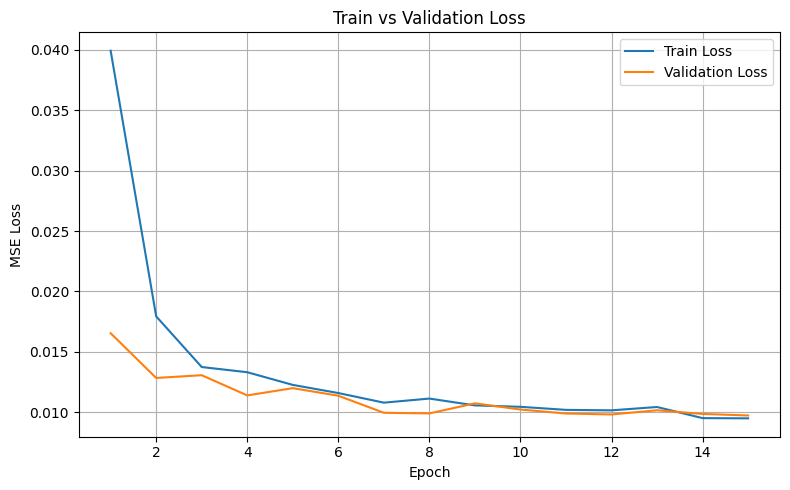

In [ ]:
import os
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.amp import autocast, GradScaler
from matplotlib import pyplot as plt
from utils import NUM_TRAIN_TIMESTEPS, sample_images, AugmentedDataset, save_checkpoint

# Config
BATCH_SIZE = 16
NUM_EPOCHS = 15
IMAGE_EXTENSIONS = (".png", ".jpg", ".jpeg")


# Dataset Preparation
def count_images(root_dir, extensions=IMAGE_EXTENSIONS):
    return sum(
        fname.lower().endswith(extensions)
        for _, _, filenames in os.walk(root_dir)
        for fname in filenames
    )


print(f"Training images before augmentation: {count_images(train_dir)}")
print(f"Validation images before augmentation: {count_images(test_dir)}")

train_dataset = AugmentedDataset(root_dir=train_dir, image_size=IMAGE_SIZE)
test_dataset = AugmentedDataset(root_dir=test_dir, image_size=IMAGE_SIZE)

train_loader = DataLoader(
    train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, pin_memory=True
)
test_loader = DataLoader(
    test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4, pin_memory=True
)

print(f"Training samples: {len(train_loader.dataset)}")
print(f"Validation samples: {len(test_loader.dataset)}")

# Scheduler and Model Setup
noise_scheduler = DDPMScheduler(num_train_timesteps=NUM_TRAIN_TIMESTEPS)
ddim_scheduler = DDIMScheduler(
    beta_start=noise_scheduler.config.beta_start,
    beta_end=noise_scheduler.config.beta_end,
    beta_schedule=noise_scheduler.config.beta_schedule,
    clip_sample=False,
)
ddim_scheduler.set_timesteps(NUM_TRAIN_TIMESTEPS)

model = torch.compile(model)
scaler = GradScaler(device=DEVICE)
scheduler = CosineAnnealingLR(optimizer, T_max=NUM_EPOCHS, eta_min=1e-6)

# Training Loop
train_losses, val_losses = [], []

print(
    f"Training on {DEVICE} | Batch Size: {BATCH_SIZE} | Epochs: {NUM_EPOCHS} | Starting at epoch {start_epoch}"
)

for epoch in range(1, NUM_EPOCHS + 1):
    model.train()
    total_train_loss = 0.0

    for step, (images, _) in enumerate(train_loader, 1):
        images = images.to(DEVICE)
        noise = torch.randn_like(images)
        timesteps = torch.randint(
            0, NUM_TRAIN_TIMESTEPS, (images.size(0),), device=DEVICE
        )

        optimizer.zero_grad()
        with autocast(device_type=DEVICE.type, enabled=True):
            noisy_images = noise_scheduler.add_noise(images, noise, timesteps)
            noise_pred = model(noisy_images, timesteps).sample
            loss = F.mse_loss(noise_pred, noise)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        scheduler.step()

        total_train_loss += loss.item()

        if step % 50 == 0 or step == len(train_loader):
            print(
                f"[Epoch {epoch}/{NUM_EPOCHS} | Step {step}/{len(train_loader)}] Train Loss: {loss.item():.6f}"
            )

        # if step % (len(train_loader) // 3) == 0:
        #     print(f"Reached step {step} of epoch {epoch}. Saving sample image and weights.")
        #     sample_images(
        #         output_path=f"{model_save_dir}/epoch_{epoch + start_epoch}_step_{step}.png",
        #         num_steps=NUM_TRAIN_TIMESTEPS,
        #         DEVICE=DEVICE,
        #         IMAGE_SIZE=IMAGE_SIZE,
        #         model=model,
        #         ddim_scheduler=ddim_scheduler,
        #     )
        #     ckpt_path = os.path.join(
        #         model_save_dir, f"ddim_unet_epoch{epoch + start_epoch}_step{step}.pth"
        #     )
        #     save_checkpoint(
        #         model=model,
        #         optimizer=optimizer,
        #         epoch=epoch + start_epoch,
        #         path=ckpt_path,
        #     )

    sample_images(
        output_path=f"{model_save_dir}/epoch_{epoch + start_epoch}.png",
        num_steps=NUM_TRAIN_TIMESTEPS,
        DEVICE=DEVICE,
        IMAGE_SIZE=IMAGE_SIZE,
        model=model,
        ddim_scheduler=ddim_scheduler,
    )

    avg_train_loss = total_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    print(f"Epoch {epoch} complete. Avg Train Loss: {avg_train_loss:.6f}")

    # Validation
    model.eval()
    total_val_loss = 0.0

    with torch.no_grad():
        for images, _ in test_loader:
            images = images.to(DEVICE)
            noise = torch.randn_like(images)
            timesteps = torch.randint(
                0, NUM_TRAIN_TIMESTEPS, (images.size(0),), device=DEVICE
            )

            with autocast(device_type=DEVICE.type, enabled=True):
                noisy_images = noise_scheduler.add_noise(images, noise, timesteps)
                noise_pred = model(noisy_images, timesteps).sample
                total_val_loss += F.mse_loss(noise_pred, noise).item()

    avg_val_loss = total_val_loss / len(test_loader)
    val_losses.append(avg_val_loss)
    print(f"Epoch {epoch} complete. Avg Validation Loss: {avg_val_loss:.6f}")

    ckpt_path = os.path.join(
        model_save_dir, f"ddim_unet_epoch{epoch + start_epoch}.pth"
    )
    save_checkpoint(
        model=model,
        optimizer=optimizer,
        epoch=epoch + start_epoch,
        path=ckpt_path,
    )

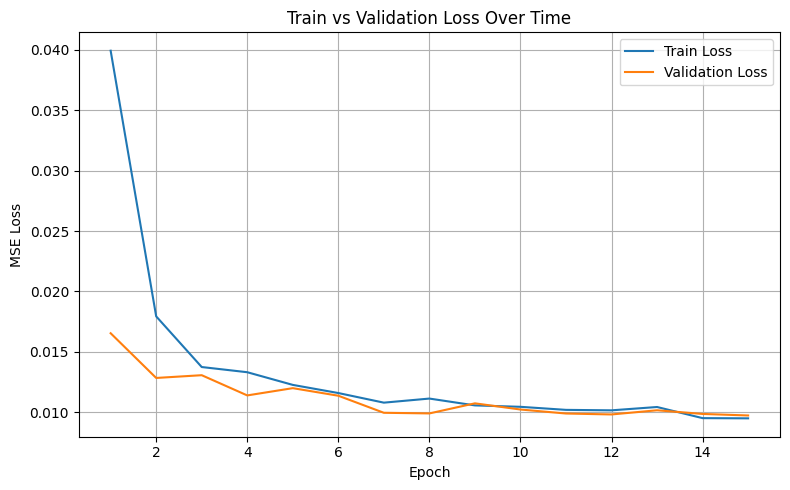

In [ ]:
import os
import numpy as np

# Path to the loss history file
history_file = os.path.join(model_save_dir, "loss_history.txt")

# Load existing history if it exists
all_train_losses = []
all_val_losses = []

if os.path.exists(history_file):
    with open(history_file, "r") as f:
        lines = f.readlines()[1:]  # Skip header
        for line in lines:
            _, train_loss, val_loss = line.strip().split("\t")
            all_train_losses.append(float(train_loss))
            all_val_losses.append(float(val_loss))

# Append current session's losses
all_train_losses.extend(train_losses)
all_val_losses.extend(val_losses)

# Save updated history
with open(history_file, "w") as f:
    f.write("Epoch\tTrain Loss\tValidation Loss\n")
    for i, (tr, vl) in enumerate(zip(all_train_losses, all_val_losses), 1):
        f.write(f"{i}\t{tr:.6f}\t{vl:.6f}\n")

# Plot full loss history
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(all_train_losses) + 1), all_train_losses, label="Train Loss")
plt.plot(range(1, len(all_val_losses) + 1), all_val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.title("Train vs Validation Loss Over Time")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [11]:
from diffusers import DDPMScheduler, DDIMScheduler
from tqdm import tqdm
from utils import sample_images

# Imposta il numero di step di inferenza per DDIM (uguale a NUM_TRAIN_TIMESTEPS di default)
# 6. Sampling example with DDIM
noise_scheduler = DDPMScheduler(num_train_timesteps=NUM_TRAIN_TIMESTEPS)

ddim_scheduler = DDIMScheduler(
    beta_start=noise_scheduler.config.beta_start,
    beta_end=noise_scheduler.config.beta_end,
    beta_schedule=noise_scheduler.config.beta_schedule,
    clip_sample=False,
)

ddim_scheduler.set_timesteps(NUM_TRAIN_TIMESTEPS)


# Sample images
for i in range(10):
    sample_images(
        output_path=f"result/ddim_sample_epoch{epoch + start_epoch}_{i}.png",
        num_steps=NUM_TRAIN_TIMESTEPS,
        DEVICE=DEVICE,
        IMAGE_SIZE=IMAGE_SIZE,
        model=model,
        ddim_scheduler=ddim_scheduler,
    )

Sampling DDIM: 100%|██████████| 1000/1000 [00:22<00:00, 44.99it/s]


Sample saved to result/ddim_sample_epoch15_0.png


Sampling DDIM: 100%|██████████| 1000/1000 [00:22<00:00, 44.70it/s]


Sample saved to result/ddim_sample_epoch15_1.png


Sampling DDIM: 100%|██████████| 1000/1000 [00:22<00:00, 44.68it/s]


Sample saved to result/ddim_sample_epoch15_2.png


Sampling DDIM: 100%|██████████| 1000/1000 [00:22<00:00, 44.87it/s]


Sample saved to result/ddim_sample_epoch15_3.png


Sampling DDIM: 100%|██████████| 1000/1000 [00:22<00:00, 44.73it/s]


Sample saved to result/ddim_sample_epoch15_4.png


Sampling DDIM: 100%|██████████| 1000/1000 [00:22<00:00, 44.77it/s]


Sample saved to result/ddim_sample_epoch15_5.png


Sampling DDIM: 100%|██████████| 1000/1000 [00:22<00:00, 44.59it/s]


Sample saved to result/ddim_sample_epoch15_6.png


Sampling DDIM: 100%|██████████| 1000/1000 [00:22<00:00, 44.47it/s]


Sample saved to result/ddim_sample_epoch15_7.png


Sampling DDIM: 100%|██████████| 1000/1000 [00:22<00:00, 44.52it/s]


Sample saved to result/ddim_sample_epoch15_8.png


Sampling DDIM: 100%|██████████| 1000/1000 [00:22<00:00, 44.57it/s]

Sample saved to result/ddim_sample_epoch15_9.png
